In [1]:
from zipfile import ZipFile
import requests
from io import BytesIO, StringIO
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
import re
import pickle
import explainerdashboard as expdb
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

#### Reading data

In [2]:
# Reading training (to build the model) and testing data (to predict the default)
response = requests.get('https://machinehack-be.s3.amazonaws.com/analytics_olympiad_2023/Participants_Data_analytics_olympiad_2023.zip?')
zip_file = ZipFile(BytesIO(response.content))
files = zip_file.namelist()
train_data=pd.read_csv(zip_file.open('train.csv'), encoding='utf8', sep=",")
test_data=pd.read_csv(zip_file.open('test.csv'), encoding='utf8', sep=",")

#### User Defined Function to Build Default Prediction Model

In [3]:
# This function takes following parameters as input values: 1. Data, 2. Feature to predict, 3. Categorical Feature list, 4. Continuous feature list
# This function returns outputs: 1. Prediction Model, 2. Feature Importances, 3. Final Features List ,4. Encoding labels (of the prediction feature)
def udf_default_prediction(data,dependent_variable,cat_features_init,cont_features_init):

    input_df=data.loc[data[dependent_variable].notnull()==True,].drop_duplicates().reset_index(drop=True)

    def udf_classification_results(input_model,input_dataframe_Y,input_dataframe_X,labels_val):
        test_predict=pd.concat([input_dataframe_Y.reset_index(drop=True),pd.Series(np.argmax(input_model.predict_proba(input_dataframe_X),axis=1))],axis=1)
        test_predict.columns=['Actual','Predicted']
        return metrics.f1_score(test_predict['Actual'],test_predict['Predicted'])

    def udf_confusion_matrix(input_model,input_dataframe_Y,input_dataframe_X,labels_val):
        test_predict=pd.concat([input_dataframe_Y.reset_index(drop=True),pd.Series(np.argmax(input_model.predict_proba(input_dataframe_X),axis=1))],axis=1)
        test_predict.columns=['Actual','Predicted']    
        confusion_matrx=metrics.confusion_matrix(test_predict['Actual'],test_predict['Predicted'])*100/test_predict.shape[0]
        sns.heatmap(confusion_matrx,annot=True,fmt='.1f',xticklabels=labels_val,yticklabels=labels_val)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def udf_feat_importance(df_ip,model_ip):
        feature_imp=pd.concat([pd.Series(df_ip.columns),pd.Series(classification_model.feature_importances_)],axis=1)
        feature_imp.columns=['Feature','Importance']
        feature_imp=feature_imp.dropna()
        feature_imp.sort_values('Importance',ascending=False,inplace=True)
        feature_imp=feature_imp.reset_index(drop=True)
        cumulative_sum=feature_imp['Importance'].sum()
        exit_loop,index_val=0,0
        while exit_loop==0:
            if feature_imp['Importance'][0:index_val].sum()/cumulative_sum>=0.75:
                exit_loop=1
            else:
                index_val+=1
        return list(feature_imp['Feature'][0:index_val])

    labels_value=input_df[dependent_variable].unique()

    encode_mapping,decode_mapping={},{}
    for cardinality in range(0,len(input_df[dependent_variable].unique())):
        encode_mapping[cardinality]=input_df[dependent_variable].unique()[cardinality]
        decode_mapping[input_df[dependent_variable].unique()[cardinality]]=cardinality

    input_df[dependent_variable]=input_df[dependent_variable].astype('category')

    # Typecasting continuous data into float data type
    input_df[cont_features_init]=input_df[cont_features_init].apply(lambda x:pd.to_numeric(x,downcast='float',errors='coerce'))
    
    input_df[cat_features_init]=input_df[cat_features_init].apply(lambda x:str(x))
    
    independent_features=list(set(cat_features_init).union(cont_features_init))
    X_df=input_df[independent_features]
    y_df=input_df[dependent_variable].map(decode_mapping)

    # Train Test Split for Modelling Data
    train_X,test_X,train_Y,test_Y=train_test_split(X_df,y_df,test_size=0.3,random_state=123)

    # Adverserial Validation
    train_adv=train_X.copy().reset_index(drop=True)
    val_adv=test_X.copy().reset_index(drop=True)
    train_adv['IsValidation']=0
    val_adv['IsValidation']=1
    adv_val_df=pd.concat([train_adv,val_adv],axis=0).reset_index(drop=True)
    x_adv_cols=list(adv_val_df.columns.difference(['IsValidation']))
    y_adv_col='IsValidation'
    train_X_adv,test_X_adv,train_Y_adv,test_Y_adv=train_test_split(adv_val_df[x_adv_cols],adv_val_df[y_adv_col],test_size=0.3,random_state=123)

    # Exclusion list of Adverserial Validation
    excluded_features=[]
    feature_threshold=0.3*train_X_adv.shape[1]
    cat_features_init_adv=cat_features_init.copy()
    cb_adv_model=CatBoostClassifier(random_seed=123,verbose=0)
    cb_adv_model.fit(train_X_adv,train_Y_adv,cat_features=cat_features_init_adv,eval_set=(test_X_adv,test_Y_adv),early_stopping_rounds=10)
    roc_auc_adv_score=metrics.roc_auc_score(test_Y_adv,pd.DataFrame(cb_adv_model.predict_proba(test_X_adv))[1])
    while roc_auc_adv_score>0.6:
        cb_adv_model=CatBoostClassifier(random_seed=123,verbose=0)
        cb_adv_model.fit(train_X_adv,train_Y_adv,cat_features=cat_features_init_adv,eval_set=(test_X_adv,test_Y_adv),early_stopping_rounds=10)
        roc_auc_adv_score=metrics.roc_auc_score(test_Y_adv,pd.DataFrame(cb_adv_model.predict_proba(test_X_adv))[1])
        adv_fe_df=pd.concat([pd.Series(train_X_adv.columns),pd.Series(cb_adv_model.feature_importances_)],axis=1)
        adv_fe_df.columns=['Feature','Importance']
        adv_fe_df=adv_fe_df.sort_values('Importance',ascending=False).reset_index(drop=True)
        excluded_features.append(adv_fe_df['Feature'][0])
        length_remaining_features=len(train_X_adv.columns.difference(excluded_features))
        if length_remaining_features>feature_threshold:
            train_X_adv=train_X_adv[train_X_adv.columns.difference(excluded_features)].reset_index(drop=True)
            test_X_adv=test_X_adv[test_X_adv.columns.difference(excluded_features)].reset_index(drop=True)
            cat_features_init_adv=list(set(cat_features_init_adv).difference(excluded_features))
        else:
            break

    # Identifying which of the of the 2 tree based models performs better
    train_X[cat_features_init]=train_X[cat_features_init].astype('category')
    test_X[cat_features_init]=test_X[cat_features_init].astype('category')
    cb_model=CatBoostClassifier(random_seed=123,verbose=0)
    cb_model.fit(train_X,train_Y,cat_features=cat_features_init,eval_set=(test_X,test_Y),early_stopping_rounds=10)
    f1_score_cb=udf_classification_results(cb_model,test_Y,test_X,labels_value)
    lgbm_model=LGBMClassifier(random_seed=123)
    lgbm_model.fit(train_X,train_Y,categorical_feature=cat_features_init,eval_set=(test_X,test_Y),early_stopping_rounds=10,verbose=0)
    f1_score_lgbm=udf_classification_results(lgbm_model,test_Y,test_X,labels_value)
    if f1_score_cb>f1_score_lgbm:
        classification_model=cb_model
    else:
        classification_model=lgbm_model

    # Feature Engineering using Feature Importance of the model
    primary_features=udf_feat_importance(train_X,classification_model)

    cat_features_fin=list(set(cat_features_init).intersection(primary_features))
    train_X=train_X[primary_features]
    test_X=test_X[primary_features]
    if str(type(classification_model)).find('LGBM')>-1:
        model_classification=LGBMClassifier(random_seed=123)
        model_classification.fit(train_X,train_Y,categorical_feature=cat_features_fin,eval_set=(test_X,test_Y),early_stopping_rounds=10,verbose=0)
    else:    
        model_classification=CatBoostClassifier(random_seed=123,verbose=0)
        model_classification.fit(train_X,train_Y,cat_features=cat_features_fin,eval_set=(test_X,test_Y),early_stopping_rounds=10)

    # Apart from top-20% features, remove other features which feature in exclusion list of Adverserial Validation
    feature_imp_df=pd.concat([pd.Series(train_X.columns),pd.Series(model_classification.feature_importances_)],axis=1)
    feature_imp_df.columns=['Feature','Importance']
    feature_imp_df=feature_imp_df.sort_values('Importance',ascending=False).reset_index(drop=True)
    num_feat_offlimits=np.ceil(feature_imp_df.shape[0]*0.2)
    features_excluded=list(set(feature_imp_df.loc[num_feat_offlimits:,'Feature']).intersection(excluded_features))

    primary_features=list(set(primary_features).difference(features_excluded))
    cat_features_fin=list(set(cat_features_init).intersection(primary_features))
    train_X=train_X[primary_features]
    test_X=test_X[primary_features]
    if str(type(classification_model)).find('LGBM')>-1:
        model_classification=LGBMClassifier(random_seed=123)
        model_classification.fit(train_X,train_Y,categorical_feature=cat_features_fin,eval_set=(test_X,test_Y),early_stopping_rounds=10,verbose=0)
    else:    
        model_classification=CatBoostClassifier(random_seed=123,verbose=0)
        model_classification.fit(train_X,train_Y,cat_features=cat_features_fin,eval_set=(test_X,test_Y),early_stopping_rounds=10)
    feature_importances_df=pd.concat([pd.Series(train_X.columns),pd.Series(model_classification.feature_importances_)],axis=1)
    feature_importances_df.columns=['Feature','Importance']
    feature_importances_df=feature_importances_df.sort_values('Importance',ascending=False).reset_index(drop=True)
    confusion_matrix_op=udf_confusion_matrix(model_classification,test_Y,test_X,labels_value)
    final_feature_list=list(train_X.columns)
    return [model_classification,feature_importances_df,final_feature_list,encode_mapping]

#### Model Building with the data

In [4]:
data=train_data.copy()

In [5]:
dependent_variable='primary_close_flag'
cat_features_init=["firstname","lastname","is_zero_loans_within_5_days","is_zero_loans_within_5_to_30_days","is_zero_loans_within_30_to_60_days","is_zero_loans_within_60_to_90_days","is_zero_loans_over_90_days","is_zero_utilization","is_zero_over_limit_count","is_zero_max_over_limit_count","encoded_payment_0","encoded_payment_1","encoded_payment_2","encoded_payment_3","encoded_payment_4","encoded_payment_5","encoded_payment_6","encoded_payment_7","encoded_payment_8","encoded_payment_9","encoded_payment_10","encoded_payment_11","encoded_payment_12","encoded_payment_13","encoded_payment_14","encoded_payment_15","encoded_payment_16","encoded_payment_17","encoded_payment_18","encoded_payment_19","encoded_payment_20","encoded_payment_21","encoded_payment_22","encoded_payment_23","encoded_payment_24","encoded_loans_account_holder_type","encoded_loans_credit_status","encoded_loans_credit_type","encoded_loans_account_currency"]
excluded_features=cat_features_init.copy()
excluded_features.append(dependent_variable)
cont_features_init=["customer_id","record_number","days_since_opened","days_since_confirmed","primary_term","final_term","days_till_primary_close","days_till_final_close","loans_credit_limit","loans_next_payment_summary","loans_outstanding_balance","loans_max_overdue_amount","loans_credit_cost_rate","loans_within_5_days","loans_within_5_to_30_days","loans_within_30_to_60_days","loans_within_60_to_90_days","loans_over_90_days","utilization","over_limit_count","max_over_limit_count"]

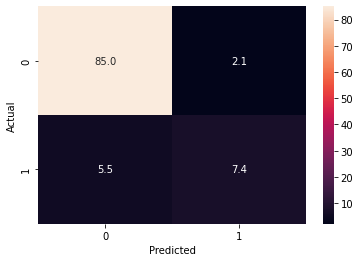

In [6]:
# Getting the prediction model on the data
prediction_model,feature_importances_res,fin_features_X,encode_map=udf_default_prediction(data,dependent_variable,cat_features_init,cont_features_init)

In [7]:
fin_features_X

['days_since_confirmed',
 'record_number',
 'loans_credit_cost_rate',
 'utilization',
 'loans_credit_limit',
 'days_since_opened']

In [8]:
# Saving the machine learning model as pickle file
pickle.dump(prediction_model, open('default_prediction_model.pkl', 'wb'))

In [9]:
# Saving the encoding lable
pickle.dump(encode_map, open("encode_map.pkl", "wb"))

#### Predicting

In [10]:
# Importing the prediction model and encoding label (of target feature)
prediction_model = pickle.load(open('default_prediction_model.pkl', 'rb'))
encode_map = pickle.load(open('encode_map.pkl', 'rb'))

In [11]:
test_data_cp=test_data.iloc[:30000,]
# test_data_cp=test_data.copy()

In [12]:
test_data_cp['customer_id']=test_data_cp.index

In [13]:
test_data_cp.set_index(test_data_cp['customer_id'],inplace=True)

In [14]:
test_data_cp['Predicted_Default']=prediction_model.predict(test_data_cp[list(feature_importances_res['Feature'])])

In [15]:
explainer=ClassifierExplainer(prediction_model, test_data_cp[feature_importances_res['Feature']],test_data_cp['Predicted_Default'] ,idxs=test_data_cp.index)
db=ExplainerDashboard(explainer,title='Default Prediction',model_summary=False,shap_dependence=False,shap_interaction=False,contribution=False)

Note: model_output=='probability'. For LGBMClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


100%|===================| 29853/30000 [01:16<00:00]        

Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating prediction probabilities...
Calculating metrics...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [16]:
db.run(host='192.168.0.8',port=8050)

Starting ExplainerDashboard on http://192.168.0.8:8050


In [ ]:
# db.run()